In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Mar 23 14:57:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers
!pip install spacy 
!pip install sentencepiece
!pip install langdetect
!pip install pytorch-lightning
!pip install fasttext
!pip3 uninstall googletrans
!pip install google_trans_new
!pip install dl-translate

     |████████████████████████████████| 2.0MB 13.8MB/s 
     |████████████████████████████████| 3.2MB 62.1MB/s 
     |████████████████████████████████| 890kB 55.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=dcc1ee6cd49aba8fad06b07700b20ed5d54b3d2e5d4f305458b191e740c71dee
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 1.2MB 14.3MB/s 
     |████████████████████████████████| 983kB 15.4MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.8-cp37-none-any.whl size=993193 sha256=0c67648e9622db09bca200417fec888e3e4eb362fe462866643f5e870859d780
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d40a60ea06e6d669e8e5012e6c8b947a57
Successfully built langdetect
     |████████████████████████████████| 829kB 16.2MB/s 
     |████████████████████████████████| 829kB 32.1MB/s 
     |███████

In [ ]:
import numpy as np
import pandas as pd
import fnmatch
import os
import fasttext
import random
import re
import threading
import librosa,librosa.display
import tensorflow as tf
from six.moves import xrange
import time
import json
import torch as t
import tqdm
import soundfile
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.distributed import DistributedSampler
from time import sleep
import torch.nn as nn
import torch.nn.functional as F
import math
import pickle
import functools
import sentencepiece
from google_trans_new import google_translator  


In [ ]:
translator = google_translator()  

In [ ]:
work_dir = '/content/drive/My Drive/Inter-IIT/'
article_path = '/content/drive/My Drive/Inter-IIT/Development Data/dev_data_article.xlsx'
tweet_path = '/content/drive/My Drive/Inter-IIT/Development Data/dev_data_tweet.xlsx'

## **Data-processing**

In [ ]:
df_art = pd.DataFrame(pd.read_excel(article_path)) 
df_tweet = pd.DataFrame(pd.read_excel(tweet_path)) 

In [ ]:
df_art.iloc[2000].Headline

'Gold Rate on 15 January 2021: लगातार गिरने के बाद संभला सोना, चांदी की कीमत में बड़ी गिरावट, जानें आज क भाव'

In [ ]:
df_art.drop(['Text_ID'],axis = 1).drop(['Headline'],axis = 1)

,Text,Mobile_Tech_Flag
0,Digitisation is one of the key buzzwords in th...,0
1,Increase in tolerance limit up to 120 per cent...,0
2,Home > News > World Sports News\n\nJonas Lossl...,0
3,"Source: Agfax.com\n\nBy Keith Brown, DTN Contr...",0
4,"United Nations, Feb 4: The Serum Institute of ...",0
...,...,...
3995,All Hindi Bloggers List with All Detail\nMay 1...,0
3996,"Amazon Flex se Part Time me Earn kare ₹15,000 ...",0
3997,Bad Link Building Strategies se Kaise Bachaye ...,0
3998,Badiya Comment karte Samay Rakhe in Baat ka Dh...,0


In [ ]:
df_art['Mobile_Tech_Flag'].value_counts()             #Counting the labels 

0    3026
1     974
Name: Mobile_Tech_Flag, dtype: int64

# **XLM-Roberta-test**

In [ ]:
# from transformers import BertTokenizer

# print("Loading the BERT tokenizer............")
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)

In [ ]:
from transformers import XLMRobertaTokenizer

tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")

In [ ]:
all_tokens = list(tokenizer.get_vocab().keys())
print(f'This is a vocab of {len(all_tokens)} tokens')

This is a vocab of 250002 tokens


In [ ]:
print(tokenizer)

PreTrainedTokenizer(name_or_path='xlm-roberta-base', vocab_size=250002, model_max_len=512, is_fast=False, padding_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=True)})


In [ ]:
with open("/content/sample_data/vocab.txt", "w") as f:
   for token in all_tokens:
       f.write(token + '\n')

In [ ]:
# Sample Tokenization 
# text = 'DeclarationofWar'
# tokens = tokenizer.tokenize(text)
# print(tokens)

In [ ]:
# Retrive the first article 

text = df_art.iloc[1].Text
tokens = tokenizer.tokenize(text)

print(f'No of tokens in this article : {len(tokens)}')

print(text)

No of tokens in this article : 939
Increase in tolerance limit up to 120 per cent (from 110 per cent) for real estate developers selling residential units meeting certain conditions:

The said proposal to increase the tolerance limit from 110 per cent to 120 per cent was initially brought in as part of AatmaNirbhar Bharat Package 3.0 on 12 November 2020 for residential units meeting the specified conditions and the legislative amendments were to be brought in due course. This is a consequential amendment made under the provisions of section 43CA & 56(2)(x) to give effect to the said announcement by the Ministry of Finance.

As pe the said provision, in case of sale of any land or building or both as stock-in-trade (other than capital asset) by an assessee, the transaction is governed by Section 43CA of the Income Tax Act, 1961 (hereinafter referred to as 'the IT Act'). The said section creates a deeming fiction whereby, the circle rate or the value adopted or assessed or assessable by 

In [ ]:
print('First 512 tokens : ')
print(tokens[:512])

First 512 tokens : 
['▁Inc', 'rea', 'se', '▁in', '▁', 'tolerance', '▁limit', '▁up', '▁to', '▁120', '▁per', '▁cent', '▁(', 'from', '▁110', '▁per', '▁cent', ')', '▁for', '▁real', '▁estate', '▁developer', 's', '▁selling', '▁residenti', 'al', '▁unit', 's', '▁meeting', '▁certain', '▁conditions', ':', '▁The', '▁said', '▁proposal', '▁to', '▁increase', '▁the', '▁', 'tolerance', '▁limit', '▁from', '▁110', '▁per', '▁cent', '▁to', '▁120', '▁per', '▁cent', '▁was', '▁initial', 'ly', '▁brought', '▁in', '▁as', '▁part', '▁of', '▁A', 'at', 'ma', 'N', 'ir', 'bhar', '▁Bharat', '▁Pack', 'age', '▁3.0', '▁on', '▁12', '▁November', '▁2020', '▁for', '▁residenti', 'al', '▁unit', 's', '▁meeting', '▁the', '▁specifi', 'ed', '▁conditions', '▁and', '▁the', '▁legislativ', 'e', '▁a', 'mend', 'ments', '▁were', '▁to', '▁be', '▁brought', '▁in', '▁due', '▁course', '.', '▁This', '▁is', '▁a', '▁consequent', 'ial', '▁a', 'mend', 'ment', '▁made', '▁under', '▁the', '▁provision', 's', '▁of', '▁section', '▁43', 'CA', '▁&', '▁56'

## **Data-preparation**

In [ ]:
# Main Tokenization here 
input_ids = []
lengths = []

print('Tokenizing comments.....')

for sen in df_art.Text:

    if(len(input_ids) % 1000 == 0):
      print(f'Read about {len(input_ids)} article!')
    

    encoded_sent = tokenizer.encode(
                            sen,
                            # max_length = 512,
                            # return_tensors = 'pt'   
                            )
    
    input_ids.append(encoded_sent)
    lengths.append(len(encoded_sent))

print('Done!')

Token indices sequence length is longer than the specified maximum sequence length for this model (941 > 512). Running this sequence through the model will result in indexing errors


Tokenizing comments.....
Read about 0 article!
Read about 1000 article!
Read about 2000 article!
Read about 3000 article!
Done!


In [ ]:
# input_ids[0][:512]

In [ ]:
labels = df_art.Mobile_Tech_Flag.to_numpy().astype(int)

print(f'No of mobile_tech labels : {np.sum(labels)}')
print(f'No of non_mobile_tech labels : {len(labels) - np.sum(labels)}')

No of mobile_tech labels : 974
No of non_mobile_tech labels : 3026


In [ ]:
print(f'Min length of tokens : {min(lengths)}')
print(f'Max length of tokens : {max(lengths)}')
print(f'Mean length of tokens : {np.mean(lengths)}')

Min length of tokens : 6
Max length of tokens : 10027
Mean length of tokens : 833.0365


In [ ]:
temp = []

for i in lengths:
    if(i > 833):
        temp.append(i)
print(len(temp))

1282


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


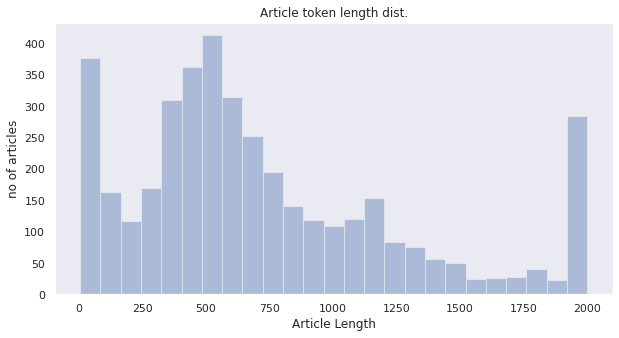

In [ ]:
#Plotting the data for knowing distributions of length if tokens!
import seaborn as sns

sns.set(style = 'dark')
plt.rcParams["figure.figsize"] = (10,5)
new_lengths = [min(l,2000) for l in lengths]

sns.distplot(new_lengths,kde=False)

plt.title('Article token length dist.')
plt.xlabel('Article Length')
plt.ylabel('no of articles')
plt.show()

# **Headline-Generation-T5**

In [ ]:
device = ('cuda' if t.cuda.is_available() else 'cpu')

In [ ]:
import argparse
import glob
import os
import json
import time
import logging
import random
import re
from itertools import chain
from string import punctuation

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from transformers import (
    AdamW,
    MT5ForConditionalGeneration,
    T5ForConditionalGeneration,
    T5Tokenizer,
    get_linear_schedule_with_warmup
)

In [ ]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

set_seed(42)

In [ ]:
df_art = pd.DataFrame(pd.read_excel(article_path)) 
df_tweet = pd.DataFrame(pd.read_excel(tweet_path)) 

In [ ]:
df_art

,Text_ID,Text,Headline,Mobile_Tech_Flag
0,article_0001,Digitisation is one of the key buzzwords in th...,Pakistan’s digital landscape post-Covid,0
1,article_0002,Increase in tolerance limit up to 120 per cent...,Affordable housing gets shot in the arm,0
2,article_0003,Home > News > World Sports News\n\nJonas Lossl...,Jonas Lossl leaves Everton to rejoin first clu...,0
3,article_0004,"Source: Agfax.com\n\nBy Keith Brown, DTN Contr...",DTN Cotton Closing: Cotton Higher on Commoditi...,0
4,article_0005,"United Nations, Feb 4: The Serum Institute of ...","Serum Institute of India, UNICEF enter into lo...",0
...,...,...,...,...
3995,article_3996,All Hindi Bloggers List with All Detail\nMay 1...,All Hindi Bloggers List with All Detail,0
3996,article_3997,"Amazon Flex se Part Time me Earn kare ₹15,000 ...","Amazon Flex se Part Time me Earn kare ₹15,000 ...",0
3997,article_3998,Bad Link Building Strategies se Kaise Bachaye ...,Bad Link Building Strategies se Kaise Bachaye ...,0
3998,article_3999,Badiya Comment karte Samay Rakhe in Baat ka Dh...,Badiya Comment karte Samay Rakhe in Baat ka Dh...,0


In [ ]:
df_art.iloc[2000].Headline

'Gold Rate on 15 January 2021: लगातार गिरने के बाद संभला सोना, चांदी की कीमत में बड़ी गिरावट, जानें आज क भाव'

In [ ]:
class LanguageIdentification:

    def __init__(self):
        PRETRAINED_MODEL_PATH = '/content/drive/MyDrive/Inter-IIT/Checkpoints/MT5/fasttext_lang_detect/lid.176.bin'
        self.model = fasttext.load_model(PRETRAINED_MODEL_PATH)

    def predict_lang(self, text):
        predictions = self.model.predict(text,k = 1) # returns top 2 matching languages
        return predictions

LANGUAGE = LanguageIdentification()

In [ ]:
headline_lang = []

for head in df_art.Headline:
    if(LANGUAGE.predict_lang(head)[0][0].split('_')[-1] == 'en' and LANGUAGE.predict_lang(head)[1][0] > 0.5):
        headline_lang.append('English')
    elif(LANGUAGE.predict_lang(head)[0][0].split('_')[-1] == 'hi' and LANGUAGE.predict_lang(head)[1][0] > 0.5):
        headline_lang.append('Hindi')
    else:
        headline_lang.append('Mix')



In [ ]:
df_art['Headline_lang'] = headline_lang

In [ ]:
df_art[df_art['Headline_lang'] == 'Mix']['Mobile_Tech_Flag'].value_counts()             

0    56
1    43
Name: Mobile_Tech_Flag, dtype: int64

In [ ]:
df_art = df_art.drop_duplicates(subset=['Text']) 

In [ ]:
df_art

,Text_ID,Text,Headline,Mobile_Tech_Flag,Headline_lang
0,article_0001,Digitisation is one of the key buzzwords in th...,Pakistan’s digital landscape post-Covid,0,English
1,article_0002,Increase in tolerance limit up to 120 per cent...,Affordable housing gets shot in the arm,0,English
2,article_0003,Home > News > World Sports News\n\nJonas Lossl...,Jonas Lossl leaves Everton to rejoin first clu...,0,English
3,article_0004,"Source: Agfax.com\n\nBy Keith Brown, DTN Contr...",DTN Cotton Closing: Cotton Higher on Commoditi...,0,English
4,article_0005,"United Nations, Feb 4: The Serum Institute of ...","Serum Institute of India, UNICEF enter into lo...",0,English
...,...,...,...,...,...
3995,article_3996,All Hindi Bloggers List with All Detail\nMay 1...,All Hindi Bloggers List with All Detail,0,English
3996,article_3997,"Amazon Flex se Part Time me Earn kare ₹15,000 ...","Amazon Flex se Part Time me Earn kare ₹15,000 ...",0,Mix
3997,article_3998,Bad Link Building Strategies se Kaise Bachaye ...,Bad Link Building Strategies se Kaise Bachaye ...,0,Mix
3998,article_3999,Badiya Comment karte Samay Rakhe in Baat ka Dh...,Badiya Comment karte Samay Rakhe in Baat ka Dh...,0,English


In [ ]:
msk = np.random.rand(len(df_art)) < 0.8

In [ ]:
train_df, test_df = train_test_split(df_art, test_size=0.2,random_state = 0)

In [ ]:
train_df = train_df.reset_index()
# train_df = train_df.drop(train_df.index)
test_df = test_df.reset_index()

In [ ]:
test_df

,index,Text_ID,Text,Headline,Mobile_Tech_Flag,Headline_lang
0,2760,article_2761,Indian Railways Recruitment 2020 For SWR Appre...,ताजा खबरें\n Indian Railways ने अपर...,0,Hindi
1,2460,article_2461,भारतीय रिजर्व बैंक (RBI) ने एक अहम फैसला लिया ...,"RBI ने इस बैंक का लाइसेंस किया रद्द, जानिए अब ...",0,Hindi
2,3181,article_3182,"Bengaluru, Feb 2 | Chinese smartphone brand Po...",Poco M3 launched in India at starting price of...,1,English
3,133,article_0134,Former President Donald Trump and the Republic...,Where's the Money? Trump Collected $175 Millio...,0,English
4,3458,article_3459,The OnePlus Nord sparked off a new class of mi...,OnePlus Nord N1 could succeed Nord N10 in 2021,1,English
...,...,...,...,...,...,...
709,1542,article_1543,Hindi News\n\nUtility\n\nZaroorat ki khabar\n\...,सुसाइड की सोच क्यों: देश में सुसाइड करने वाले ...,0,Hindi
710,2220,article_2221,2020 की ईयर एंडर सेल के बाद होंडा की ओर से गाड...,टॉप कार मॉडल्स पर 2.5 लाख रुपए तक की छूट दे रह...,0,Hindi
711,2,article_0003,Home > News > World Sports News\n\nJonas Lossl...,Jonas Lossl leaves Everton to rejoin first clu...,0,English
712,3060,article_3061,"Gurugram: Expanding its successful 'M' series,...",Business\n Samsung launches afforda...,1,English


## **T5-Model**

In [ ]:
class MT5FineTuner(pl.LightningModule):
  def __init__(self, train_df, test_df, hparams):
    super(MT5FineTuner, self).__init__()
    self.hparams = hparams
    self.train_df = train_df
    self.test_df = test_df
    self.model = MT5ForConditionalGeneration.from_pretrained(hparams.model_name_or_path)
    self.tokenizer = T5Tokenizer.from_pretrained(hparams.tokenizer_name_or_path)
  
  def is_logger(self):
    return self.trainer.global_rank <= 0
  
  def forward(
      self, input_ids, attention_mask=None, decoder_input_ids=None, decoder_attention_mask=None, lm_labels=None
  ):
    return self.model(
        input_ids,
        attention_mask=attention_mask,
        decoder_input_ids=decoder_input_ids,
        decoder_attention_mask=decoder_attention_mask,
        labels=lm_labels,
    )

  def _step(self, batch):
    lm_labels = batch["target_ids"]
    lm_labels[lm_labels[:, :] == self.tokenizer.pad_token_id] = -100

    outputs = self(
        input_ids=batch["source_ids"],
        attention_mask=batch["source_mask"],
        lm_labels=lm_labels,
        decoder_attention_mask=batch['target_mask']
    )

    loss = outputs[0]

    return loss

  def training_step(self, batch, batch_idx):
    loss = self._step(batch)

    tensorboard_logs = {"train_loss": loss}
    return {"loss": loss, "log": tensorboard_logs}
  
  def training_epoch_end(self, outputs):
    print(outputs)
    avg_train_loss = torch.stack([x["loss"] for x in outputs]).mean()
    tensorboard_logs = {"avg_train_loss": avg_train_loss}
    return {"avg_train_loss": avg_train_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

  def validation_step(self, batch, batch_idx):
    loss = self._step(batch)
    return {"val_loss": loss}
  
  def validation_epoch_end(self, outputs):
    avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
    tensorboard_logs = {"val_loss": avg_loss}
    return {"avg_val_loss": avg_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

  def configure_optimizers(self):
    "Prepare optimizer and schedule (linear warmup and decay)"

    model = self.model
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": self.hparams.weight_decay,
        },
        {
            "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
            "weight_decay": 0.0,
        },
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=self.hparams.learning_rate, eps=self.hparams.adam_epsilon)
    self.opt = optimizer
    return [optimizer]
  
  def optimizer_step(self, epoch, batch_idx, optimizer, optimizer_idx, second_order_closure=None, on_tpu=False, using_native_amp=False, using_lbfgs=False):
    if self.trainer.use_tpu:
      xm.optimizer_step(optimizer)
    else:
      optimizer.step()
    optimizer.zero_grad()
    self.lr_scheduler.step()
  
  def get_tqdm_dict(self):
    tqdm_dict = {"loss": "{:.3f}".format(self.trainer.avg_loss), "lr": self.lr_scheduler.get_last_lr()[-1]}

    return tqdm_dict

  def train_dataloader(self):
    train_dataset = get_dataset(tokenizer=self.tokenizer, df=self.train_df, type_path="train", args=self.hparams)
    print(len(train_dataset))
    dataloader = DataLoader(train_dataset, batch_size=self.hparams.train_batch_size, drop_last=True, shuffle=True, num_workers=4)
    t_total = (
        (len(dataloader.dataset) // (self.hparams.train_batch_size * max(1, self.hparams.n_gpu)))
        // self.hparams.gradient_accumulation_steps
        * float(self.hparams.num_train_epochs)
    )
    scheduler = get_linear_schedule_with_warmup(
        self.opt, num_warmup_steps=self.hparams.warmup_steps, num_training_steps=t_total
    )
    self.lr_scheduler = scheduler
    return dataloader

  def val_dataloader(self):
    val_dataset = get_dataset(tokenizer=self.tokenizer, df=self.test_df, type_path="val", args=self.hparams)
    print(len(val_dataset))
    return DataLoader(val_dataset, batch_size=self.hparams.eval_batch_size, num_workers=4)

## **Data-preparation**

In [ ]:
import dl_translate as dlt

mt = dlt.TranslationModel()  # Slow when you load it for the first time


In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import wordpunct_tokenize
import pickle
nltk.download('stopwords')

with open("/content/drive/MyDrive/Inter-IIT/dictionary.pickle", "rb") as translit:
  translit_dic = pickle.load(translit)
  
def translit_text(text, translit_dic):

    english_stopwords_set = set(stopwords.words('english'))
    tokens = wordpunct_tokenize(text)
    words = [word.lower() for word in tokens]

    translit_text = ""

    for word in words:
        if word in english_stopwords_set:
            translit_text = translit_text + " " + word
        elif (word in translit_dic):
            translit_text = translit_text + " " + translit_dic[word]
        else:
            translit_text = translit_text + " " + word

    return translit_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
train_df[train_df['Headline_lang'] == 'Mix']

,index,Text_ID,Text,Headline,Mobile_Tech_Flag,Headline_lang
55,3990,article_3991,About Us Page Kaise Banaye Website/Blog ke liy...,About Us Page Kaise Banaye Website/Blog ke liy...,0,Mix
74,1490,article_1491,Biogen Announces FDA Approval of PLEGRIDY® (pe...,Biogen Announces FDA Approval of PLEGRIDY® (pe...,0,Mix
171,3978,article_3979,101 Top Useful Website list [2019]\nNovember 3...,101 Top Useful Website list [2019],0,Mix
250,3422,article_3423,Infinix recently launched its mid-budget smart...,Product Review: Infinix Zero 8i Smartphone,1,Mix
285,382,article_0383,The past year may have impacted several catego...,GAMING: THE NEXT FRONTIER,0,Mix
...,...,...,...,...,...,...
2697,3489,article_3490,MediaTek has released its new M80 5G modem whi...,MediaTek Introduces New M80 5G Modem,1,Mix
2756,3950,article_3951,250+ Badiya Blogger SEO Friendly or Mobile Fri...,250+ Badiya Blogger SEO Friendly or Mobile Fri...,1,Mix
2781,3490,article_3491,Xiaomi is all set to launch a toned down versi...,Xiaomi Mi 11 Lite Coming With 120Hz IPS LCD Di...,1,Mix
2812,3968,article_3969,Mobile Fast Charge Kaise kare | 📲 Phone Fast C...,Mobile Fast Charge Kaise kare | 📲 Phone Fast C...,1,Mix


In [ ]:
print(train_df.iloc[55].Headline)
print(translit_text(train_df.iloc[55].Headline, translit_dic))

About Us Page Kaise Banaye Website/Blog ke liye or Usme Kya Likhe
 about उस  page कैसे बनाए वेबसाईट** / blog  के  लिए or उसमें क्या लिखे


In [ ]:
class HeadlineDataset(Dataset):
    def __init__(self, tokenizer, df, type_path, max_len=512):

        self.source_column = "Text"
        self.target_column = "Headline"
        self.target_label_column = "Headline_lang"
        self.data = df
        self.max_len = max_len
        self.tokenizer = tokenizer
        self.inputs = []
        self.targets = []

        self._build()

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, index):
        source_ids = self.inputs[index]["input_ids"].squeeze()
        target_ids = self.targets[index]["input_ids"].squeeze()

        src_mask = self.inputs[index]["attention_mask"].squeeze()  # might need to squeeze
        target_mask = self.targets[index]["attention_mask"].squeeze()  # might need to squeeze

        return {"source_ids": source_ids, "source_mask": src_mask, "target_ids": target_ids, "target_mask": target_mask}

    def _build(self):
        for idx in range(len(self.data)):
            input_, target, target_lan = self.data.loc[idx, self.source_column], self.data.loc[idx, self.target_column], self.data.loc[idx, self.target_label_column]

            #if target_lan == 'Mix':


            input_ = target_lan + " Headline: "+ input_ + ' </s>'
            if target_lan == 'Hindi':
              target = mt.translate(target, source=dlt.lang.HINDI, target=dlt.lang.ENGLISH)
            target = target + " </s>"

            # tokenize inputs
            tokenized_inputs = self.tokenizer.batch_encode_plus(
                [input_], max_length=self.max_len, pad_to_max_length=True, return_tensors="pt"
            )
            # tokenize targets
            tokenized_targets = self.tokenizer.batch_encode_plus(
                [target], max_length=self.max_len, pad_to_max_length=True, return_tensors="pt"
            )

            self.inputs.append(tokenized_inputs)
            self.targets.append(tokenized_targets)

In [ ]:
tokenizer = T5Tokenizer.from_pretrained('google/mt5-small')

In [ ]:
#dataset = HeadlineDataset(tokenizer, test_df, 'train',  max_len=512)
#len(dataset)

In [ ]:
#data = dataset[74]
#print(tokenizer.decode(data['source_ids']))
#print(tokenizer.decode(data['target_ids']))

In [ ]:
def get_dataset(tokenizer, df, type_path, args):
  return HeadlineDataset(tokenizer=tokenizer, df=df, type_path=type_path,  max_len=args.max_seq_length)

## **Pytorch-base**

In [ ]:
save_model = True
load_model = True

In [ ]:
model = MT5ForConditionalGeneration.from_pretrained('google/mt5-small')
tokenizer = T5Tokenizer.from_pretrained('google/mt5-small')

In [ ]:
train_dataset = HeadlineDataset(tokenizer=tokenizer, df=train_df, type_path='train',  max_len=512)
train_loader = DataLoader(train_dataset, batch_size=1, drop_last=True, shuffle=True, num_workers=4)

In [ ]:
model.cuda()

In [ ]:
optimizer = AdamW(model.parameters(), lr = 1e-4, eps = 1e-8)

In [ ]:
from transformers import get_linear_schedule_with_warmup

# num epochs
epochs = 25

# Total training steps is basically  no. of batches * total epochs 
total_training_steps = len(train_loader)*epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_training_steps)

In [ ]:
PATH = '/content/drive/My Drive/Inter-IIT/Checkpoints/MT5'
checkpoint_path = '/content/drive/My Drive/Inter-IIT/Checkpoints/MT5/checkpoint_latest.pt'

In [ ]:
if(load_model):
  checkpoint = torch.load(checkpoint_path)
  model.load_state_dict(checkpoint['model_state_dict'])
  # optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
  # epoch = checkpoint['epoch']
  # loss = checkpoint['loss']

In [ ]:
from tqdm import tqdm

loss_values = []

for i in range(0, epochs):
    print("")
    print(f"======= Epoch {i + 1}/{epochs} =======")
    print("Training.....")

    total_loss = 0 
    model.train()
    
    for step, batch in enumerate(tqdm(train_loader)):
        optimizer.zero_grad()
        lm_labels = batch["target_ids"]
        lm_labels[lm_labels[:, :] == tokenizer.pad_token_id] = -100
        
        input_ids=batch["source_ids"].cuda()
        attention_mask=batch["source_mask"].cuda()
        lm_labels=lm_labels.cuda()
        decoder_attention_mask=batch['target_mask'].cuda()
        
        # Forward Pass
        outputs = model(input_ids,
                      attention_mask=attention_mask,
                      decoder_input_ids=None,
                      decoder_attention_mask=decoder_attention_mask,
                      labels=lm_labels)
        loss = outputs[0]
        total_loss += loss.item()
        
        # Backward Pass 
        loss.backward()
        t.nn.utils.clip_grad_norm_(model.parameters(),1.0)
        optimizer.step()
        scheduler.step()

    avg_loss = (total_loss / len(train_loader))
    print(f'The average Training Loss after {i + 1} epochs : {avg_loss}')
    loss_values.append(avg_loss)

    if(save_model):
      print(f'Saving Checkpoint =>')
      t.save({
              'epoch': i,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'scheduler_state_dict' : scheduler.state_dict(),
              'loss': avg_loss,
              }, PATH + f'/checkpoint_latest.pt')


## **Evaluation**

In [ ]:
dataset = HeadlineDataset(tokenizer, test_df, 'test',  max_len=512)
data = dataset[90]

In [ ]:
article = tokenizer.decode(data['source_ids'])
label = tokenizer.decode(data['target_ids'])
print(article)
print(label)

In [ ]:
article = test_df.iloc[10].Text
print(article)

In [ ]:
# text = "Hindi Headline: " + article 

# max_len = 64

# encoding = tokenizer.encode_plus(text,pad_to_max_length=True, return_tensors="pt")
# input_ids, attention_masks = encoding["input_ids"].to(device), encoding["attention_mask"].to(device)

# # set top_k = 50 and set top_p = 0.95 and num_return_sequences = 3
# beam_outputs = model.generate(
#     input_ids=input_ids, attention_mask=attention_masks,
#     do_sample=True,
#     max_length=64,
#     top_k=120,
#     top_p=0.98,
#     early_stopping=True,
#     num_return_sequences=10
# )


# # print ("\nOriginal Question ::")
# # print (sentence)
# # print ("\n")
# # print ("Paraphrased Questions :: ")
# final_outputs =[]
# for beam_output in beam_outputs:
#     sent = tokenizer.decode(beam_output, skip_special_tokens=True,clean_up_tokenization_spaces=True)
#     # if sent.lower() != sentence.lower() and sent not in final_outputs:
#     final_outputs.append(sent)

# for i, final_output in enumerate(final_outputs):
#     print("{}: {}".format(i, final_output))

In [ ]:
article = '''
Realme 8 और Realme 8 Pro स्मार्टफोन के लिए प्री-बुकिंग Flipkart पर लॉन्च से पहले लाइव हो गई है। यह स्मार्टफोन 24 मार्च को भारत में लॉन्च किए जाएंगे। ई-कॉमर्स वेबसाइट पर एक नई माइक्रो साइट लाइव की गई है, जिसमें जानकारी दी गई है कि Realme 8 सीरीज़ 24 मार्च को भारत में शाम 7.30 बजे लॉन्च होगी। यही नहीं, इसके जरिए सीरीज़ के स्मार्टफोन के प्रमुख स्पेसिफिकेशन की जानकारी के साथ-साथ रियलमी 8 और रिलमी 8 प्रो स्मार्टफोन को प्री-बुक करने का भी मौका मिल रहा है। रियलमी 8 सीरीज़ के लॉन्च की जानकारी को Realme India YouTube चैनल के जरिए भी टीज़ किया गया है। Realme 8 series pre-orders Realme 8 सीरीज़ की प्री-बुकिंग आज 15 मार्च दोपहर 12 बजे से शुरू कर दी गई है, जो कि 22 मार्च तक चलेगी। Realme 8 और Realme 8 Pro स्मार्टफोन की प्री-बुकिंग के लिए आपको Flipkart पेज पर जाना होगा और वहां खुद को रजिस्टर करना होगा। इसके बाद आपको 1,080 रुपये की कीमत वाला Flipkart Electronic Gift Voucher खरीदना होगा और 24 मार्च को एक बार फिर वेबसाइट पर विजिट करना होगा जब रियलमी 8 सीरीज़ डिवाइस के लिए सेल तारीख का ऐलान कर दिया जाएगा। रियलमी 8 सीरीज़ फोन की प्री-बुकिंग करने वाले ग्राहकों को Realme Buds Air Neo ट्रू वायरलेस स्टीरियो ईयरफोन 50 प्रतिशत छूट के साथ खरीदने का मौका मिलेगा, जो कि पिछले साल लॉन्च हुए थे। उन्हें Flipkart app पर ट्रू वायरलेस ईयरफोन खरीदने के लिए एक डिस्काउंट कूपन दिया जाएगा। प्री-बुकिंग कराने वाले ग्राहकों को रियलमी 8 सीरीज़ के फोन 10 दिनों के अंदर प्राप्त होंगे। डिस्काउंट के बाद रियलमी बड्स नियो एयर की कीमत 1,499 रुपये हो जाएगी। Realme 8 and Realme 8 Pro specifications (expected) फ्लिपकार्ट पेज के माध्यम से पुष्टि होती है कि रियलमी 8 सीरीज़ में 108 मेगापिक्सल का कैमरा फीचर होगा। 108 मेगापिक्सल कैमरे में 9 इन 1 पिक्सल बाइनिंग मिलेगी, जो कि लो-लाइट फोटोग्राफी में मदद करेगी। इसमें टाइम लैप्स वीडियोज़ के लिए Starry Mode और 3x zoom दिया जाएगा। हालांकि, यह फीचर सीरीज़ के टॉप-एंड Realme 8 Pro स्मार्टफोन में मिलेंगे। फ्लिपकार्ट माइक्रो साइट के अनुसार, रियलमी 8 प्रो 176 ग्राम भारी होगा और 8.1mm मोटा। गौरतलब है कि प्रो वेरिएंट कथित रूप से यूएस एफसीसी लिस्टिंग पर लिस्ट हुआ था, जिससे संकेत मिला था कि रियलमी 8 प्रो फोन में 4,500 एमएएच की बैटरी के साथ 65 वॉट फास्ट चार्जिंग सपोर्ट मिलेगा। कंपनी के सीईओ माधव सेठ द्वारा ने ट्विटर पर एक तस्वीर पोस्ट की थी जिसमें रियलमी 8 का पिछला हिस्सा देखा जा सकता है, जिसमें फोन के कुछ स्पेसिफिकेशन की जानकारी का खुलासा किया गया है। जैसे कि यह फोन 6.4 इंच सुपर एमोलेड डिस्प्ले और मीडियाटेक हीलियो जी95 प्रोसेसर से लैस होगा। फोन में क्वाड रियर कैमरा सेटअप मौजूद होगा, जिसका प्राइमरी कैमरा 64 मेगापिक्सल का होगा। इसके अलावा, फोन की बैटरी 5,000 एमएएच की होगी, जिसके साथ 30 वॉट डार्ट चार्ज फास्ट चार्जिंग सपोर्ट मिलेगा। COMMENTS लेटेस्ट टेक न्यूज़, स्मार्टफोन रिव्यू और लोकप्रिय मोबाइल पर मिलने वाले एक्सक्लूसिव ऑफर के लिए गैजेट्स 360 एंड्रॉयड ऐप डाउनलोड करें और हमें गूगल समाचार पर फॉलो करें।
'''

text =  "English Headline: " + article

encoding = tokenizer.encode_plus(text, return_tensors = "pt")
input_ids = encoding["input_ids"].to(device)
attention_masks = encoding["attention_mask"].to(device)

beam_outputs = model.generate(
              input_ids = input_ids,
              attention_mask = attention_masks,
              max_length = 64,
              num_beams = 3,
              early_stopping =  True,
              )

result = tokenizer.decode(beam_outputs[0])
print(result)

In [ ]:
# import dl_translate as dlt

# mt = dlt.TranslationModel()  # Slow when you load it for the first time


In [ ]:
print(mt.available_languages())  # All languages that you can use

In [ ]:
text_hi = result
mt.translate(text_hi, source=dlt.lang.HINDI, target=dlt.lang.ENGLISH)

In [ ]:
translator.translate(result)

In [ ]:
# translator.translate(result[5:-4])

In [ ]:
# article = ''' 
# michromax in 1 smaartaphon 19 maarch ko lonch kiya jaega. lonch se pahale yah phon ee-komars vebasait flipkart par list kar diya gaya hai, jahaan smaartaphon ke dizain ko dekha ja sakata hai. vebasait par in 1 phon ko indiya ka naya blokabastar bataaya gaya hai, jahaan isakee khoobiyon ko boleevud philmon ke naam die gae hain, jaise geming ka galee boy, disple ka don, kaimare ka khilaadee, daata ka dabang aur stail ka suparastaar. yahee nahin, phlipakaart listing ke alaava, xd  devalapar dvaara is phon ke spesiphikeshan kee jaanakaaree bhee onalain leek kee gaee hai.

# '''

# text =  'English' + ' Headline: ' + article 

# encoding = tokenizer.encode_plus(text, return_tensors = "pt")
# input_ids = encoding["input_ids"].to(device)
# attention_masks = encoding["attention_mask"].to(device)

# beam_outputs = model.generate(
#               input_ids = input_ids,
#               attention_mask = attention_masks,
#               max_length = 64,
#               num_beams = 3,
#               early_stopping =  True,
#               )

# result = tokenizer.decode(beam_outputs[0])
# print(result)


In [ ]:
text =  "Hindi" + " Headline: " + article + " </s>"


max_len = 64

encoding = tokenizer.encode_plus(text,pad_to_max_length=True, return_tensors="pt")
input_ids, attention_masks = encoding["input_ids"].to(device), encoding["attention_mask"].to(device)


# set top_k = 50 and set top_p = 0.95 and num_return_sequences = 3
beam_outputs = model.generate(
    input_ids=input_ids, attention_mask=attention_masks,
    do_sample=True,
    max_length=64,
    top_k=150,
    top_p=0.95,
    early_stopping=True,
    num_return_sequences=1
)


# print ("\nOriginal Question ::")
# print (sentence)
# print ("\n")
# print ("Paraphrased Questions :: ")
final_outputs =[]
for beam_output in beam_outputs:
    sent = tokenizer.decode(beam_output, skip_special_tokens=True,clean_up_tokenization_spaces=True)
    # if sent.lower() != sentence.lower() and sent not in final_outputs:
    final_outputs.append(sent)

for i, final_output in enumerate(final_outputs):
    print("{}: {}".format(i, final_output))

In [ ]:
# from google_trans_new import google_translator
# from pprint import pprint

# # init the Google API translator
# def convert_all2eng(head_list):
#     translator = google_translator()
#     eng_list = []
#     for i, head in enumerate(head_list):
#         #print(hi)
#         print('Headline {}'.format(i+1))
#         # translate a hinglish text to english text (by default)
#         print(head)
#         translation = translator.translate(head)
#         print(translation)
#         translation = translator.translate(translation)
#         eng_list.append(translation)
#     return eng_list

In [ ]:
final_outputs

In [ ]:
eng_list = convert_all2eng(final_outputs[:5])

In [ ]:
eng_list

## **Training-Lightning**

In [ ]:
logger = logging.getLogger(__name__)

class LoggingCallback(pl.Callback):
  def on_validation_end(self, trainer, pl_module):
    logger.info("***** Validation results *****")
    if pl_module.is_logger():
      metrics = trainer.callback_metrics
      # Log results
      for key in sorted(metrics):
        if key not in ["log", "progress_bar"]:
          logger.info("{} = {}\n".format(key, str(metrics[key])))

  def on_test_end(self, trainer, pl_module):
    logger.info("***** Test results *****")

    if pl_module.is_logger():
      metrics = trainer.callback_metrics

      # Log and save results to file
      output_test_results_file = os.path.join(pl_module.hparams.output_dir, "test_results.txt")
      with open(output_test_results_file, "w") as writer:
        for key in sorted(metrics):
          if key not in ["log", "progress_bar"]:
            logger.info("{} = {}\n".format(key, str(metrics[key])))
            writer.write("{} = {}\n".format(key, str(metrics[key])))

In [ ]:
args_dict = dict(
    data_dir="", # path for data files
    output_dir="", # path to save the checkpoints
    model_name_or_path='google/mt5-small',
    tokenizer_name_or_path='google/mt5-small',
    max_seq_length=512,
    learning_rate=1e-4,
    weight_decay=0.0,
    adam_epsilon=1e-8,
    warmup_steps=0,
    train_batch_size=8,
    eval_batch_size=8,
    num_train_epochs=2,
    gradient_accumulation_steps=1,
    n_gpu=1,
    early_stop_callback=False,
    fp_16=False, # if you want to enable 16-bit training then install apex and set this to true
    opt_level='O1', # you can find out more on optimisation levels here https://nvidia.github.io/apex/amp.html#opt-levels-and-properties
    max_grad_norm=1.0, # if you enable 16-bit training then set this to a sensible value, 0.5 is a good default
    seed=42,
)

In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint

args_dict.update({'output_dir': 't5_imdb_sentiment', 'num_train_epochs':2})
args = argparse.Namespace(**args_dict)

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath=args.output_dir, prefix="checkpoint", monitor="val_loss", mode="min", save_top_k=5
)

train_params = dict(
    accumulate_grad_batches=args.gradient_accumulation_steps,
    gpus=args.n_gpu,
    max_epochs=args.num_train_epochs,
    # early_stop_callback=False,
    precision= 16 if args.fp_16 else 32,
    amp_level=args.opt_level,
    gradient_clip_val=args.max_grad_norm,
    checkpoint_callback=checkpoint_callback,
    callbacks=[LoggingCallback()],
)

In [ ]:
# model = MT5FineTuner(train_df, test_df, args)

In [ ]:
# trainer = pl.Trainer(**train_params)

In [ ]:
# trainer.fit(model)

# **NER + Sentiment Analyisis**

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")
model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")

nlp = pipeline("ner", model=model, tokenizer=tokenizer)

In [ ]:
sequence = """ Four new Nokia 5G smartphones will be reportedly announced this year.

Advertisement

HMD Global is planning to launch affordable 5G Nokia smartphones in India. Company's Vice President Sanmeet Kochhar has revealed the brand’s plan for 2021 in an interview. He acknowledged the Indian market as “important” and that it will be catered by “customized” Nokia devices.



In an interview to Financial Express, Sanmeet Kocchar said, “We are looking at India as an important market and the first thing that we are going to do is look at products which are customized for the Indian market. Second is 5G, which is an important space that we have decided to play in, and we are looking at how we can launch more affordable 5G devices this year.”



Further, he said “Our overall focus will be on communicating our differentiation from competitors. Our differentiation lies in terms of having a better, future-proof software. When you are buying a Nokia phone, you are getting software which is going to last for much longer and then you will not be forced to change your device (as frequently).”





For India becoming an export hub, the VP said “India as a source for our exports is something that we are evaluating very closely. It is difficult to give a timeframe, but as I said, India is an important market for us, and we will continue to evaluate India, not only for our domestic consumption, but also from an export point of view.”

Earlier in an interview to The Mobile Indian as well, Sanmeet Kocchar said that in 2021, the company will launch unique products which will be focussed for the India market and targeted at Indian fans. You can see the video below:

Advertisement

As per an earlier report, four new Nokia 5G smartphones will be announced this year. However, all these smartphones will not be launched altogether but two of them may be launched in the first half of 2021 while the two smartphones will be launched in the second half of 2021.



Meanwhile, Nokia 1.4 along with 6.3, 7.3 were recently reported to launch in Q1 or Q2 of 2021. Nokia 1.4 price of the Nokia 1.4 also leaked online. The Nokia 1.4 price in the UK is said to be £83 (around Rs 8,400/$114). To recall, its predecessor, the Nokia 1.3 launched at $99 in the US.



The phone will come with 1GB RAM and 16GB storage variant. The phone will also be made available in a Blue colour variant. Nokia 1.4 is expected to come in Blue and Grey colour options.



 """

In [ ]:
# function to preprocess speech
def clean(text):
    
    # removing paragraph numbers
    text = re.sub('[0-9]+,\t\'"";:<>~`!@#$%^&*()_-+={}','',str(text))
    # removing new line characters
    text = re.sub('\n ','',str(text))
    text = re.sub('\n',' ',str(text))
    # removing apostrophes
    text = re.sub("'s",'',str(text))
    # removing hyphens
    text = re.sub("-",' ',str(text))
    text = re.sub("— ",'',str(text))
    # removing quotation marks
    text = re.sub('\"','',str(text))
    # removing salutations
    text = re.sub("Mr\.",'Mr',str(text))
    text = re.sub("Mrs\.",'Mrs',str(text))
    # removing any reference to outside text
    text = re.sub("[\(\[].*?[\)\]]", "", str(text))
    
    return text

# preprocessing speeches
sequence = clean(sequence)

In [ ]:
entities = nlp(sequence)
store_en = ''
for dictt in entities:
  if dictt['entity'] == 'B-ORG' or dictt['entity'] == 'I-ORG':
    if dictt['word'][0] == '#':
      store_en += dictt['word'][2:]
    elif dictt['entity'] == 'B-ORG':
      store_en += ' ' + dictt['word'] 
    print(dictt) 

store_en = store_en.split()
store_en = list(dict.fromkeys(store_en))
if 'the' in store_en:
  store_en.remove('the')
if 'The' in store_en:
  store_en.remove('The')
store_en

In [ ]:
#inn = 0
#while inn < (len(store_en)):
#  if inn == 0:
#    inn += 1
#    continue
#  if abs(re.split("\s|(?<!\d)[,.](?!\d)", sequence).index(store_en[inn].split()[-1]) - re.split("\s|(?<!\d)[,.](?!\d)", sequence).index(store_en[inn-1].split()[-1])) == 1:
#    store_en[inn-1] += ' ' + store_en[inn]
#    store_en.remove(store_en[inn])
#  else:
#    inn += 1
#store_en

In [ ]:
def sentences(text):
    # split sentences and questions
    text = re.split('[.?]', text)
    clean_sent = []
    for i, sent in enumerate(text):
        try:
          if i!= 0 and (isinstance(int(clean_sent[-1][-1]), int) and isinstance(int(sent[0]), int)):
            clean_sent[-1] = clean_sent[-1] + sent
          else:
            clean_sent.append(sent)
        except:
          clean_sent.append(sent)
    return clean_sent

ind_sent = sentences(clean_text)

In [ ]:
ind_sent

In [ ]:
longest_string_len = len(max(ind_sent, key=len))
longest_string_len

In [ ]:
ent_dict = dict()
for ent in store_en:
  ent_dict[ent] = 0

In [ ]:
ent_dict

In [ ]:
from transformers import XLMRobertaForSequenceClassification

output_dir = '/content/drive/MyDrive/Inter-IIT/Checkpoints/XLM-R-sentiment/'

In [ ]:
from transformers import XLMRobertaTokenizer
import torch
# Load the BERT tokenizer.
print('Loading XLMRobertaTokenizer...')
tokenizer = XLMRobertaTokenizer.from_pretrained(output_dir)
model_loaded = XLMRobertaForSequenceClassification.from_pretrained(output_dir, output_attentions=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_loaded = model_loaded.to(device)

In [ ]:
def intersection(lst1, lst2): 
    # Use of hybrid method 
    temp = set(lst2) 
    lst3 = [value for value in lst1 if value in temp] 
    return lst3 

In [ ]:
for sent in ind_sent:
  matched_ent = intersection(sent.split(), store_en)
  print(matched_ent)
  for orgg in matched_ent:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = longest_string_len,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    # Add the encoded sentence to the list.    
    input_id = encoded_dict['input_ids']
    # And its attention mask (simply differentiates padding from non-padding).
    attention_mask = encoded_dict['attention_mask']
    input_id = torch.LongTensor(input_id)
    attention_mask = torch.LongTensor(attention_mask)
    input_id = input_id.to(device)
    attention_mask = attention_mask.to(device)

    with torch.no_grad():
        # Forward pass, calculate logit predictions
        attentions = model_loaded(input_id, token_type_ids=None, attention_mask=attention_mask)[-1][11]
    # print(outputs[0])
    

# **Trash - Dont mind us**

In [ ]:
from transformers import AutoModelForTokenClassification, AutoTokenizer
import torch

model = AutoModelForTokenClassification.from_pretrained("dbmdz/bert-large-cased-finetuned-conll03-english")
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

In [ ]:
label_list = [
    "O",       # Outside of a named entity
    "B-MISC",  # Beginning of a miscellaneous entity right after another miscellaneous entity
    "I-MISC",  # Miscellaneous entity
    "B-PER",   # Beginning of a person's name right after another person's name
    "I-PER",   # Person's name
    "B-ORG",   # Beginning of an organisation right after another organisation
    "I-ORG",   # Organisation
    "B-LOC",   # Beginning of a location right after another location
    "I-LOC"    # Location
]

sequence = df_art.iloc[3002].Text
df_temp = df_art[df_art['Mobile_Tech_Flag'] == 1]

print(df_temp)

In [ ]:
# Bit of a hack to get the tokens with the special tokens
tokens = tokenizer.tokenize(tokenizer.decode(tokenizer.encode(sequence)))
inputs = tokenizer.encode(sequence, return_tensors="pt")
print(inputs.shape)

outputs = model(inputs[:,:512])[0]
predictions = torch.argmax(outputs, dim=2)

print([(token, label_list[prediction]) for token, prediction in zip(tokens, predictions[0].tolist()) if label_list[prediction] == "I-ORG"])

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import wordpunct_tokenize
import pickle
import codecs

In [ ]:
def translateHinglishTweets(tweets_text):
	counter = 0
	tweets_text_translated = []
	n = len(tweets_text)

	open_file = open("dictionary.pickle", "rb")
	dictionary = pickle.load(open_file)
	open_file.close()

	english_stopwords_set = set(stopwords.words('english'))

	for i in range(n):
		text = tweets_text[i]
		translated_text = ""
		tokens = wordpunct_tokenize(text)
		words = [word.lower() for word in tokens]
		for word in words:
			if word in english_stopwords_set:
				translated_text = translated_text + " " + word
			elif (word in dictionary):
				#print word + "-" + dictionary[word]
				translated_text = translated_text + " " + dictionary[word]
				counter = counter + 1
			else:
				translated_text = translated_text + " " + word
		tweets_text_translated.append(translated_text)

	#print counter
	return tweets_text_translated

In [ ]:
text = df_tweet.iloc[3998].Tweet

In [ ]:
lis = translateHinglishTweets([text])